# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

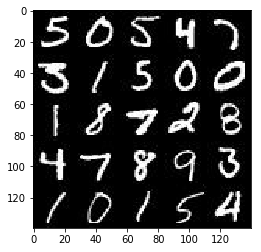

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

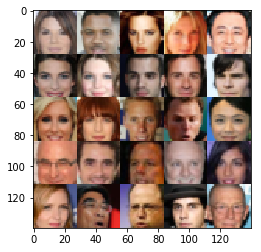

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function    
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Image Rescaling
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
               # print the generator output every 100 batches.    
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode) 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.8479... Generator Loss: 7.7861
Epoch 1/2... Discriminator Loss: 0.9294... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 1.6135
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 2.0820
Epoch 1/2... Discriminator Loss: 2.1225... Generator Loss: 1.9076
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 2.0326
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 1.2890
Epoch 1/2... Discriminator Loss: 2.2481... Generator Loss: 1.3559
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 0.4521


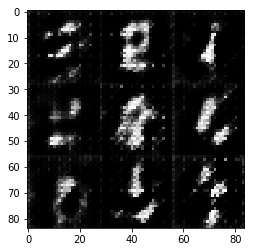

Epoch 1/2... Discriminator Loss: 1.5868... Generator Loss: 0.3286
Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.6778... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.7771... Generator Loss: 1.6480
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 1.4083
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.1972
Epoch 1/2... Discriminator Loss: 1.4028... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 0.3809


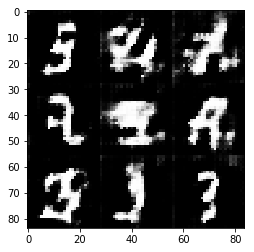

Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 1.6741... Generator Loss: 0.2997
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 0.9775
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 0.4094
Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.3161
Epoch 1/2... Discriminator Loss: 2.2737... Generator Loss: 2.8727
Epoch 1/2... Discriminator Loss: 2.0440... Generator Loss: 0.2100
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 1.5997


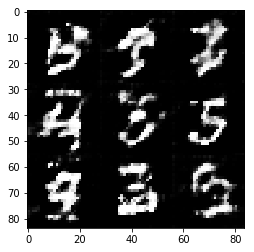

Epoch 1/2... Discriminator Loss: 1.8741... Generator Loss: 0.2270
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 1.7855... Generator Loss: 0.4449
Epoch 1/2... Discriminator Loss: 1.7849... Generator Loss: 0.2798
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.3991... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.2242... Generator Loss: 1.3174
Epoch 1/2... Discriminator Loss: 1.4556... Generator Loss: 1.7280
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.4906


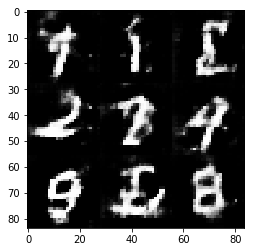

Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.6769
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.8919
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.4546... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 1.1866... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 1.7446... Generator Loss: 1.6514
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 0.9353
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.7123
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.4102
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.3828


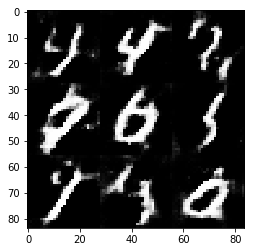

Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.4672
Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 1.3645
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.4470
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.0084... Generator Loss: 1.3248
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.3627
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 1.6726
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.6429


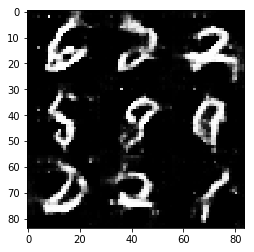

Epoch 1/2... Discriminator Loss: 1.5429... Generator Loss: 0.4016
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 1.7771... Generator Loss: 0.2793
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 1.3491... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.4999


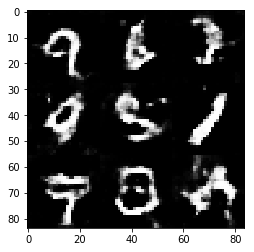

Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 0.9728... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 0.9488... Generator Loss: 1.1108
Epoch 1/2... Discriminator Loss: 1.8502... Generator Loss: 0.2990
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 1.9851
Epoch 1/2... Discriminator Loss: 1.5529... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3755... Generator Loss: 0.5627


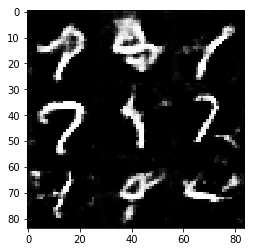

Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 0.9258... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 2.3261... Generator Loss: 0.1781
Epoch 1/2... Discriminator Loss: 1.7505... Generator Loss: 0.2837
Epoch 1/2... Discriminator Loss: 2.1736... Generator Loss: 0.1855
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.3156
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 0.9871... Generator Loss: 1.6803
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.4500
Epoch 1/2... Discriminator Loss: 1.9924... Generator Loss: 0.2437


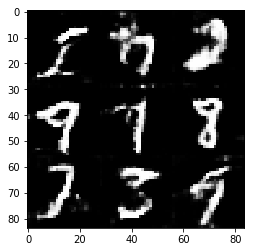

Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.4578
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 1.5364
Epoch 1/2... Discriminator Loss: 1.0413... Generator Loss: 1.4275
Epoch 1/2... Discriminator Loss: 1.9097... Generator Loss: 0.2313
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.5638
Epoch 1/2... Discriminator Loss: 1.4881... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.0675... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5039
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.3931


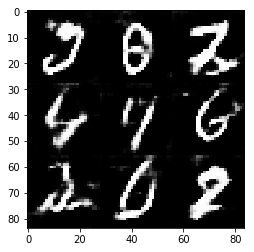

Epoch 1/2... Discriminator Loss: 2.2471... Generator Loss: 0.1622
Epoch 1/2... Discriminator Loss: 1.8116... Generator Loss: 0.2940
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 0.8503... Generator Loss: 1.7399
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.4812
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.5425
Epoch 1/2... Discriminator Loss: 2.0119... Generator Loss: 0.3096
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 0.8963


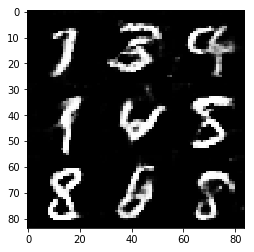

Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 0.6481
Epoch 1/2... Discriminator Loss: 2.5595... Generator Loss: 0.1450
Epoch 1/2... Discriminator Loss: 0.8514... Generator Loss: 1.1129
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 1.3442
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 0.4788
Epoch 1/2... Discriminator Loss: 2.1850... Generator Loss: 0.2020
Epoch 1/2... Discriminator Loss: 1.7253... Generator Loss: 0.2823
Epoch 1/2... Discriminator Loss: 0.7513... Generator Loss: 1.9966


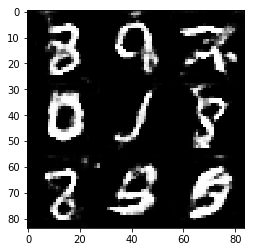

Epoch 1/2... Discriminator Loss: 1.6053... Generator Loss: 0.5810
Epoch 1/2... Discriminator Loss: 2.0648... Generator Loss: 0.3382
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 2.1231... Generator Loss: 0.2236
Epoch 1/2... Discriminator Loss: 2.3914... Generator Loss: 0.1844
Epoch 1/2... Discriminator Loss: 2.2418... Generator Loss: 0.2033
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 1.5023
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.8709
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.5406


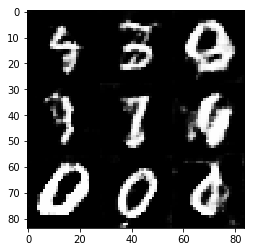

Epoch 1/2... Discriminator Loss: 0.4159... Generator Loss: 1.7419
Epoch 1/2... Discriminator Loss: 1.5632... Generator Loss: 0.4365
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 2.7493... Generator Loss: 0.1766
Epoch 1/2... Discriminator Loss: 2.5836... Generator Loss: 0.1501
Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 1.2554
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 0.8413... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.7585


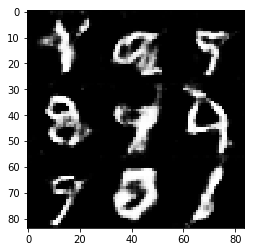

Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 0.9663
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 2.5365
Epoch 1/2... Discriminator Loss: 2.7067... Generator Loss: 0.1881
Epoch 1/2... Discriminator Loss: 0.5488... Generator Loss: 1.4568
Epoch 1/2... Discriminator Loss: 0.9056... Generator Loss: 1.2151
Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 1.1290
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.4176
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.1019


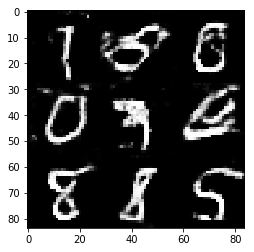

Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.3587
Epoch 1/2... Discriminator Loss: 2.0011... Generator Loss: 0.3821
Epoch 1/2... Discriminator Loss: 2.4237... Generator Loss: 0.2161
Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 1.5766
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 0.5578... Generator Loss: 1.5763
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 4.2606
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.5778
Epoch 1/2... Discriminator Loss: 0.7304... Generator Loss: 2.2469


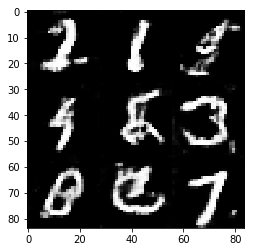

Epoch 1/2... Discriminator Loss: 2.2177... Generator Loss: 0.2072
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 2.1154
Epoch 1/2... Discriminator Loss: 2.6302... Generator Loss: 0.1323
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 1.2199
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 0.4450... Generator Loss: 1.6143
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 0.9717
Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 0.9919
Epoch 1/2... Discriminator Loss: 0.4455... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 0.9474


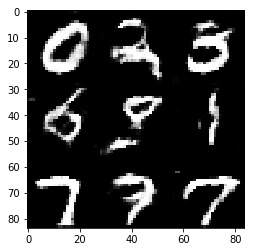

Epoch 1/2... Discriminator Loss: 0.3462... Generator Loss: 1.7520
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.7167... Generator Loss: 0.3146
Epoch 1/2... Discriminator Loss: 0.6397... Generator Loss: 1.3965
Epoch 1/2... Discriminator Loss: 2.2453... Generator Loss: 4.1119
Epoch 1/2... Discriminator Loss: 0.5194... Generator Loss: 2.0573
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 4.1606
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.4942


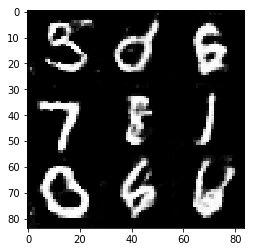

Epoch 1/2... Discriminator Loss: 0.9983... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.3267... Generator Loss: 0.4235
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.3880
Epoch 2/2... Discriminator Loss: 2.6590... Generator Loss: 0.1750
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.4756... Generator Loss: 0.4270


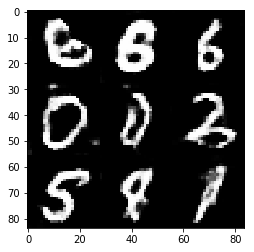

Epoch 2/2... Discriminator Loss: 1.5613... Generator Loss: 0.4645
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 2.4650... Generator Loss: 0.2628
Epoch 2/2... Discriminator Loss: 0.2526... Generator Loss: 2.7018
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.5352
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.4809
Epoch 2/2... Discriminator Loss: 0.7231... Generator Loss: 1.0986
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 0.9423
Epoch 2/2... Discriminator Loss: 0.4691... Generator Loss: 1.7031
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.4808


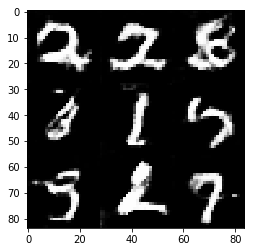

Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.3520
Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 1.6429
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.6969
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.4444
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.6315
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.5808... Generator Loss: 0.4357
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 0.9881


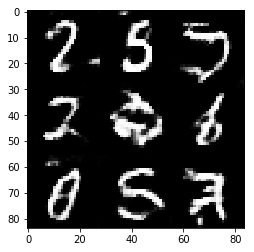

Epoch 2/2... Discriminator Loss: 0.8869... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 0.6140... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 0.7686
Epoch 2/2... Discriminator Loss: 0.6064... Generator Loss: 1.5177
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 1.1301
Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.7069
Epoch 2/2... Discriminator Loss: 0.3274... Generator Loss: 1.9487
Epoch 2/2... Discriminator Loss: 0.3539... Generator Loss: 2.0195
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.4092


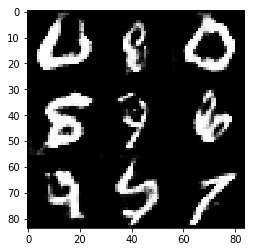

Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 0.8678
Epoch 2/2... Discriminator Loss: 1.0435... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.1847
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.2493
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.6432
Epoch 2/2... Discriminator Loss: 1.6751... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.7732
Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 0.9594


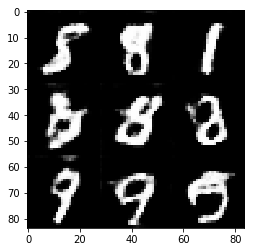

Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 2.1923
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 1.2462
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 0.4459... Generator Loss: 1.6579
Epoch 2/2... Discriminator Loss: 0.4061... Generator Loss: 2.2920
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 3.4063
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 0.5405... Generator Loss: 1.4945
Epoch 2/2... Discriminator Loss: 0.2753... Generator Loss: 1.9749
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 6.6842


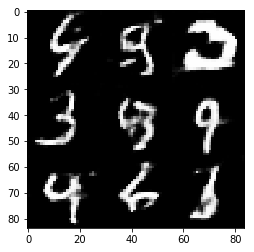

Epoch 2/2... Discriminator Loss: 0.7993... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.5335
Epoch 2/2... Discriminator Loss: 2.5480... Generator Loss: 0.2366
Epoch 2/2... Discriminator Loss: 2.1975... Generator Loss: 0.2987
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.7913
Epoch 2/2... Discriminator Loss: 2.4532... Generator Loss: 0.3343
Epoch 2/2... Discriminator Loss: 0.4463... Generator Loss: 2.1112
Epoch 2/2... Discriminator Loss: 0.5964... Generator Loss: 1.6773
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.0436
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.1430


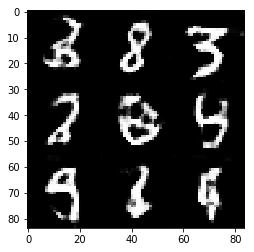

Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 1.2845
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 0.7886... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 1.4979... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 0.8068... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.5418... Generator Loss: 0.6129
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 0.9389
Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.4443
Epoch 2/2... Discriminator Loss: 0.5377... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.3655


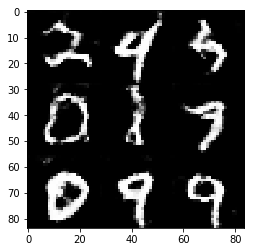

Epoch 2/2... Discriminator Loss: 0.2374... Generator Loss: 2.1583
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 0.9875
Epoch 2/2... Discriminator Loss: 0.1934... Generator Loss: 2.6802
Epoch 2/2... Discriminator Loss: 0.9681... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 0.5885... Generator Loss: 1.7339
Epoch 2/2... Discriminator Loss: 0.3926... Generator Loss: 1.7999
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 1.5757
Epoch 2/2... Discriminator Loss: 2.7274... Generator Loss: 7.4015
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.4223
Epoch 2/2... Discriminator Loss: 0.2726... Generator Loss: 2.9164


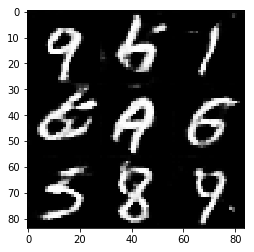

Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 1.7886
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 3.6870
Epoch 2/2... Discriminator Loss: 1.2198... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 0.3497... Generator Loss: 1.9430
Epoch 2/2... Discriminator Loss: 1.4758... Generator Loss: 5.2648
Epoch 2/2... Discriminator Loss: 0.3640... Generator Loss: 2.3261
Epoch 2/2... Discriminator Loss: 1.8896... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.1835... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.6032... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 2.5675... Generator Loss: 0.2776


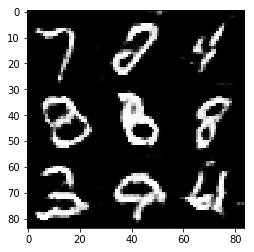

Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 1.2354... Generator Loss: 0.7038
Epoch 2/2... Discriminator Loss: 0.6280... Generator Loss: 1.8652
Epoch 2/2... Discriminator Loss: 0.9236... Generator Loss: 0.8887
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.0269
Epoch 2/2... Discriminator Loss: 3.1106... Generator Loss: 6.7489
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.2137
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 2.1235
Epoch 2/2... Discriminator Loss: 0.5251... Generator Loss: 1.5778
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.2503


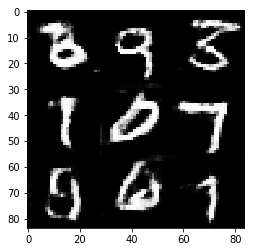

Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 0.9387
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 1.7184... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 0.7201... Generator Loss: 1.0423
Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.5978
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 1.8562
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.6171


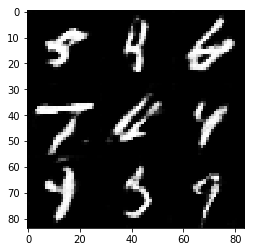

Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 1.2075
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.5679
Epoch 2/2... Discriminator Loss: 1.8275... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 2.1681... Generator Loss: 5.5325
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.7471


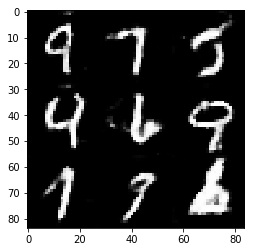

Epoch 2/2... Discriminator Loss: 1.5673... Generator Loss: 0.5628
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 2.0534
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 2.1299... Generator Loss: 0.2951
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.6869
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 1.4719
Epoch 2/2... Discriminator Loss: 2.4726... Generator Loss: 0.2073
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 1.4692
Epoch 2/2... Discriminator Loss: 1.4897... Generator Loss: 0.4764


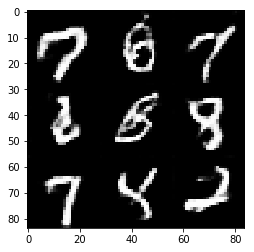

Epoch 2/2... Discriminator Loss: 0.3330... Generator Loss: 1.9415
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 1.9199
Epoch 2/2... Discriminator Loss: 0.2450... Generator Loss: 4.2573
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.8788
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.0849
Epoch 2/2... Discriminator Loss: 0.2017... Generator Loss: 2.6691
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 0.4236... Generator Loss: 3.1017
Epoch 2/2... Discriminator Loss: 1.3866... Generator Loss: 1.2504


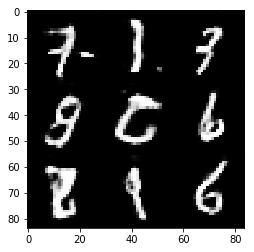

Epoch 2/2... Discriminator Loss: 0.3888... Generator Loss: 4.5102
Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 2.5130
Epoch 2/2... Discriminator Loss: 1.8189... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 0.3749... Generator Loss: 1.9176
Epoch 2/2... Discriminator Loss: 0.1841... Generator Loss: 3.5880
Epoch 2/2... Discriminator Loss: 0.4190... Generator Loss: 2.4975
Epoch 2/2... Discriminator Loss: 2.4962... Generator Loss: 0.2992
Epoch 2/2... Discriminator Loss: 0.4244... Generator Loss: 2.0265
Epoch 2/2... Discriminator Loss: 0.2839... Generator Loss: 4.2662
Epoch 2/2... Discriminator Loss: 1.3033... Generator Loss: 0.8869


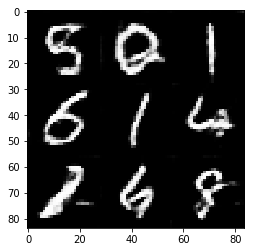

Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.4693... Generator Loss: 0.4059
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.0023
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.7456
Epoch 2/2... Discriminator Loss: 0.4021... Generator Loss: 2.3765
Epoch 2/2... Discriminator Loss: 0.4634... Generator Loss: 1.7423
Epoch 2/2... Discriminator Loss: 0.6593... Generator Loss: 1.2534
Epoch 2/2... Discriminator Loss: 1.3250... Generator Loss: 0.8989
Epoch 2/2... Discriminator Loss: 0.5448... Generator Loss: 1.8839
Epoch 2/2... Discriminator Loss: 2.0111... Generator Loss: 0.3744


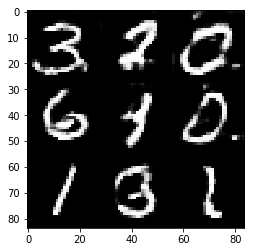

Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.6560... Generator Loss: 0.4497
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.0352
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 1.3716
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 0.3275... Generator Loss: 2.0466
Epoch 2/2... Discriminator Loss: 0.2281... Generator Loss: 2.2290
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.4868


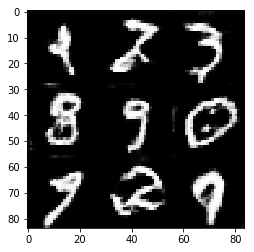

Epoch 2/2... Discriminator Loss: 0.5045... Generator Loss: 1.9151
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 3.2433... Generator Loss: 0.1280
Epoch 2/2... Discriminator Loss: 0.4522... Generator Loss: 4.7394
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.3966
Epoch 2/2... Discriminator Loss: 2.2173... Generator Loss: 0.2589
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.6317
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.4907
Epoch 2/2... Discriminator Loss: 1.6903... Generator Loss: 0.5076
Epoch 2/2... Discriminator Loss: 1.7200... Generator Loss: 0.7998


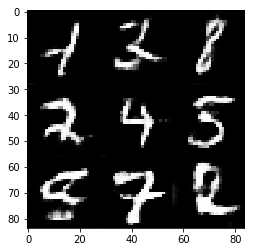

Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.4305
Epoch 2/2... Discriminator Loss: 0.2405... Generator Loss: 2.9824
Epoch 2/2... Discriminator Loss: 0.4936... Generator Loss: 1.8878
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 2.3155


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9483... Generator Loss: 1.6208
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 3.5615... Generator Loss: 4.6179
Epoch 1/1... Discriminator Loss: 2.3006... Generator Loss: 0.2825
Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 0.5847... Generator Loss: 1.6298
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.3808
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 2.2055
Epoch 1/1... Discriminator Loss: 1.8641... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 0.1680... Generator Loss: 5.9769


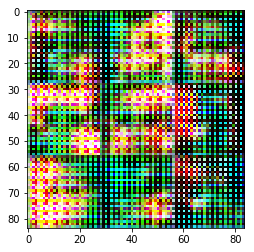

Epoch 1/1... Discriminator Loss: 0.1682... Generator Loss: 3.5335
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 3.9935
Epoch 1/1... Discriminator Loss: 1.7351... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.9841... Generator Loss: 5.7082
Epoch 1/1... Discriminator Loss: 2.5074... Generator Loss: 0.1484
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 1.7510
Epoch 1/1... Discriminator Loss: 0.3905... Generator Loss: 2.3292
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.6999
Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 2.1563


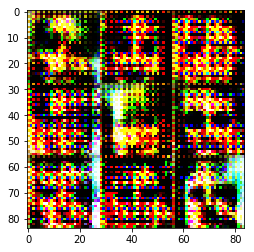

Epoch 1/1... Discriminator Loss: 0.2575... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 1.8127
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 4.0259
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 5.6432
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 5.1316
Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 3.9776
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 5.3375
Epoch 1/1... Discriminator Loss: 2.2759... Generator Loss: 2.0475
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7988


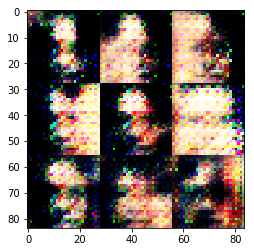

Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 2.3844... Generator Loss: 0.1820
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 2.2308... Generator Loss: 0.2430


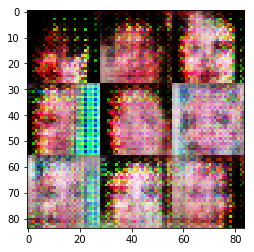

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.4725
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.4862
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.8447... Generator Loss: 1.9773
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 1.0110
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.0880


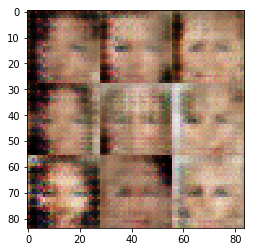

Epoch 1/1... Discriminator Loss: 1.6379... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.9135... Generator Loss: 0.3033
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.6532... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.7451


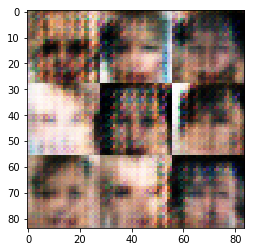

Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.4839
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.2563
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.4694


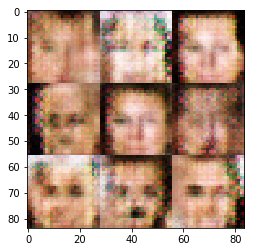

Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 1.6569
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 2.0474... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0531


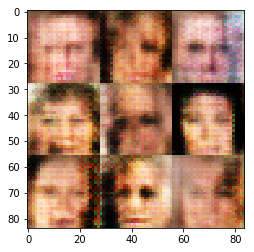

Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 2.2434... Generator Loss: 2.0856
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.8800


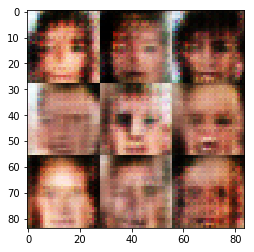

Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6286


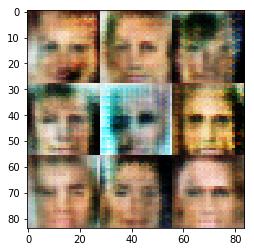

Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.6815


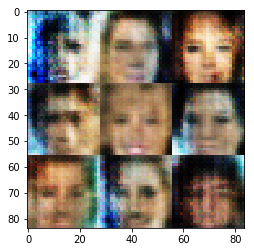

Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 1.0346
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7415


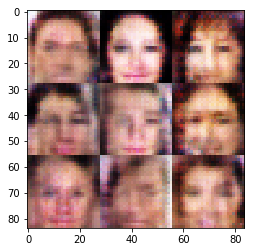

Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.9238... Generator Loss: 0.2641
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.9965
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.5182


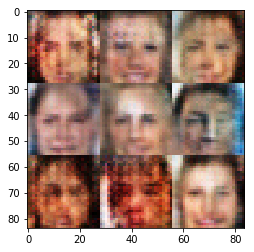

Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.5601... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.5753... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.6627


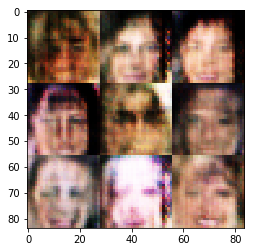

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.7447... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6748


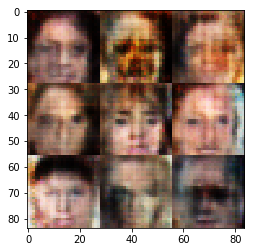

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.5104
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6808


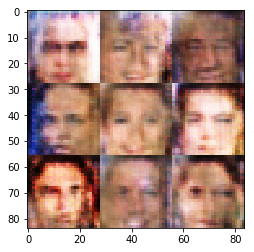

Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.1289... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.5602


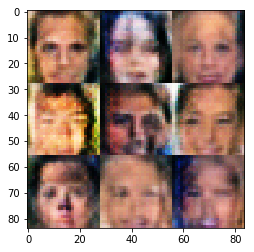

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8677


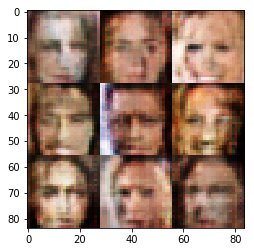

Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4887


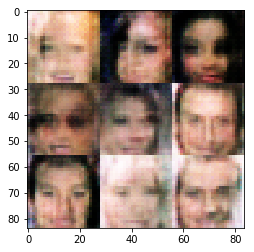

Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6048


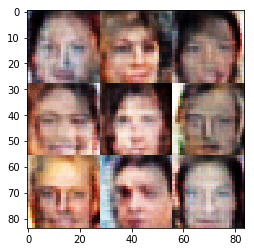

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7007


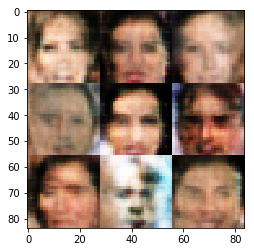

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.2321
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.4751
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5400


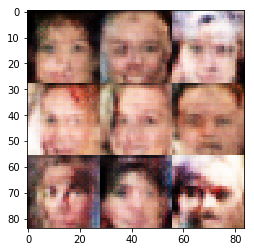

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.5003
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 1.2473
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5778


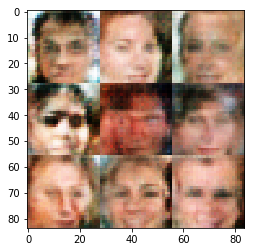

Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 1.5966
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.8943... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7507


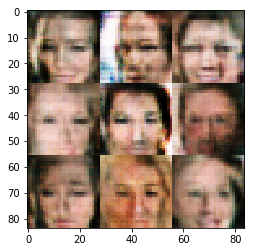

Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.4021
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.3830
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6606


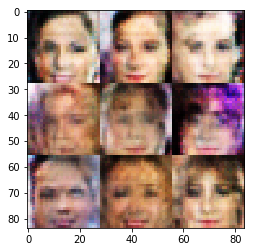

Epoch 1/1... Discriminator Loss: 0.9638... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.8058... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 1.8386... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.5444


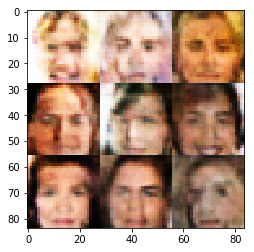

Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.3663
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4053


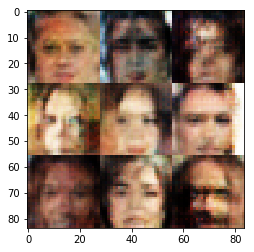

Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.8535
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5214


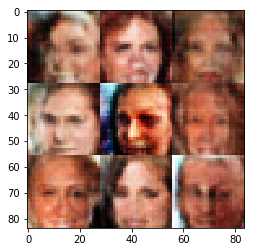

Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 1.2181
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.4184


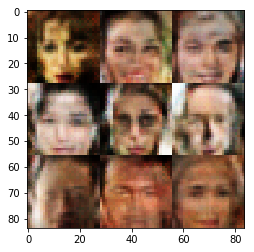

Epoch 1/1... Discriminator Loss: 2.1119... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.7730... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.4575


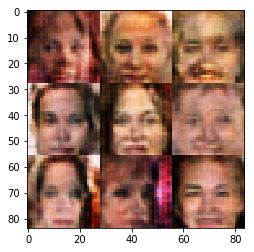

Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.8973
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6165


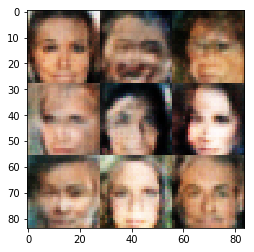

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 2.0118
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.6179... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7649


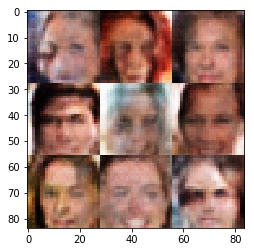

Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 0.1313... Generator Loss: 3.0841
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.5555
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.4602
Epoch 1/1... Discriminator Loss: 1.6292... Generator Loss: 0.2708


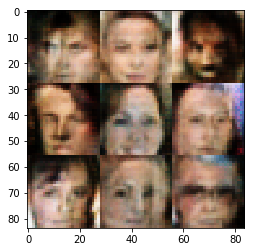

Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6520


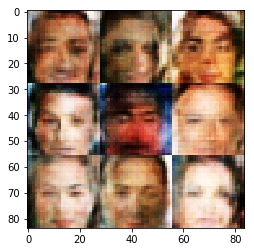

Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.3701
Epoch 1/1... Discriminator Loss: 3.0345... Generator Loss: 2.1119
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 5.4253... Generator Loss: 5.6072
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6706


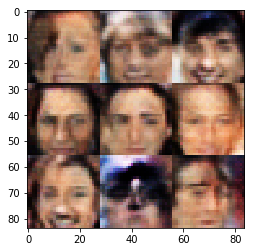

Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 1.8600... Generator Loss: 0.3128
Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 0.3810


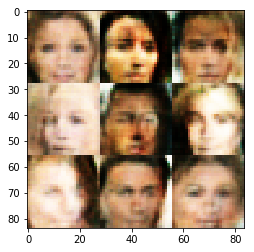

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 0.5814... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 1.7045... Generator Loss: 0.3850
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.7209


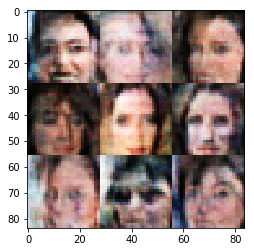

Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.4813


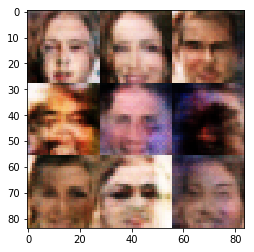

Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6587


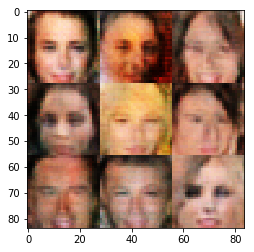

Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.0518
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.5215
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.5518... Generator Loss: 0.3210


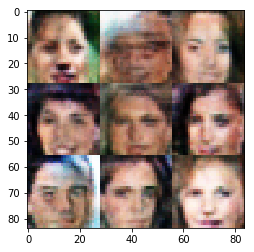

Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.5849... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.0850
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.0470... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3245


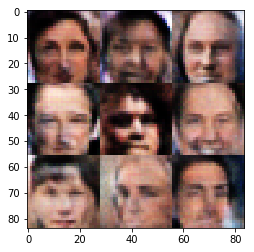

Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.6254
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.3018
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7631


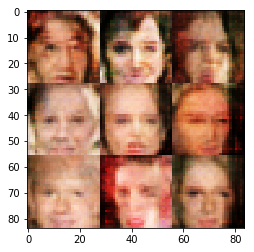

Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.3916
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.6361... Generator Loss: 0.3888


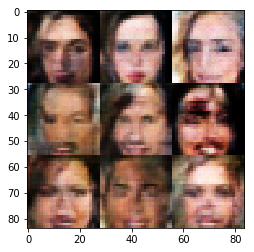

Epoch 1/1... Discriminator Loss: 1.7868... Generator Loss: 0.2428
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.8578... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.5993


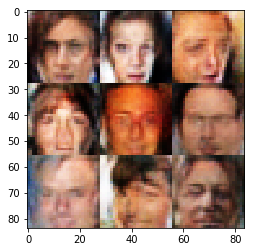

Epoch 1/1... Discriminator Loss: 0.8651... Generator Loss: 1.8020
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.5801
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 0.7505


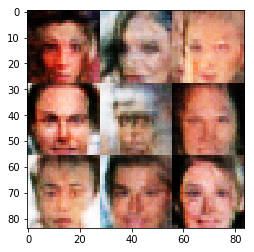

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.4142
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5834


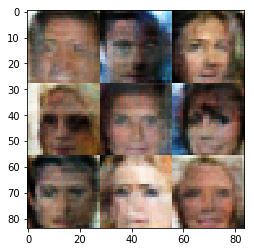

Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.7580... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.7498


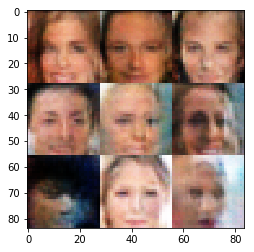

Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8301


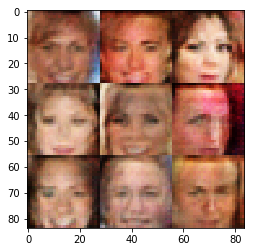

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 1.5638


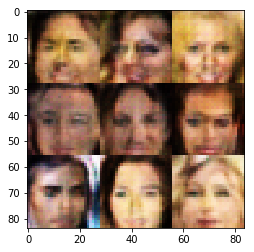

Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 2.3498
Epoch 1/1... Discriminator Loss: 3.0177... Generator Loss: 3.5812
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 1.6280
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.5922


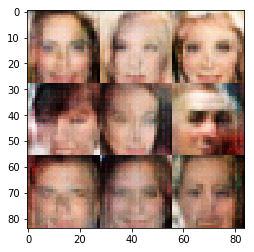

Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.4118
Epoch 1/1... Discriminator Loss: 1.8533... Generator Loss: 1.7709
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.5359


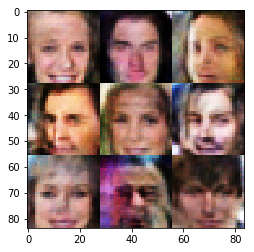

Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 2.2933... Generator Loss: 2.0190
Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 2.2946
Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 1.6477
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.4946
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.6392


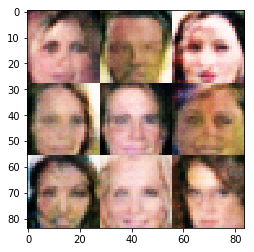

Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 0.4529... Generator Loss: 1.1390
Epoch 1/1... Discriminator Loss: 2.5783... Generator Loss: 2.9642
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 4.2584
Epoch 1/1... Discriminator Loss: 0.2517... Generator Loss: 1.7655
Epoch 1/1... Discriminator Loss: 0.1339... Generator Loss: 2.4239


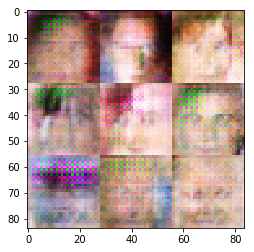

Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 3.7866
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 4.4651
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 5.0782
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 4.9780
Epoch 1/1... Discriminator Loss: 0.0046... Generator Loss: 5.7735
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 4.5089
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 5.1028
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 21.5542
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 9.2674
Epoch 1/1... Discriminator Loss: 0.0184... Generator Loss: 6.9481


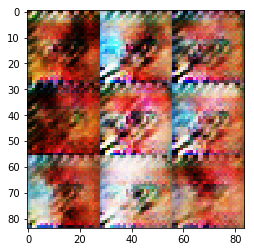

Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 7.7122
Epoch 1/1... Discriminator Loss: 0.0045... Generator Loss: 7.0965
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 6.4479
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.3292
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 7.0523
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 2.7624... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6529


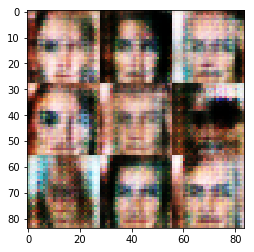

Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 1.7355... Generator Loss: 0.3236
Epoch 1/1... Discriminator Loss: 1.9080... Generator Loss: 0.2307
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 4.3755
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.4024
Epoch 1/1... Discriminator Loss: 1.7395... Generator Loss: 0.2865
Epoch 1/1... Discriminator Loss: 0.2024... Generator Loss: 2.0763
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.0410
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 0.3047... Generator Loss: 1.9523


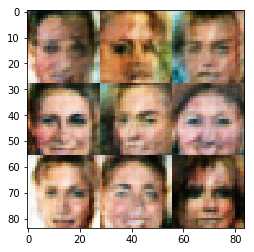

Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.1366
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.1484... Generator Loss: 2.7334
Epoch 1/1... Discriminator Loss: 0.5332... Generator Loss: 1.8688
Epoch 1/1... Discriminator Loss: 0.1095... Generator Loss: 2.7352
Epoch 1/1... Discriminator Loss: 0.2307... Generator Loss: 1.9469
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.4891
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 0.3079
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.7873


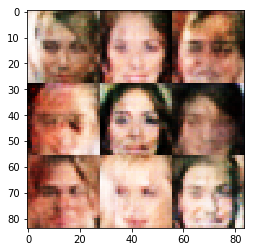

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.3666
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.4812
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.4395


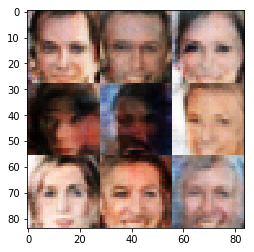

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 1.9790
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.4184
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 0.6639


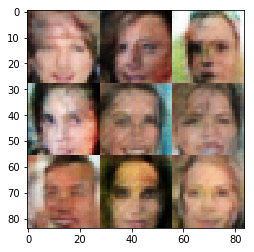

Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 2.6155
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.5498... Generator Loss: 1.8925


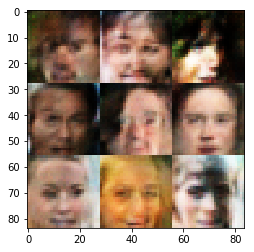

Epoch 1/1... Discriminator Loss: 1.9398... Generator Loss: 0.4840
Epoch 1/1... Discriminator Loss: 1.8046... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 2.2747... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 1.5601
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6683


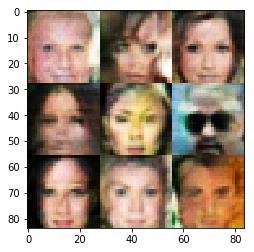

Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 2.1038... Generator Loss: 0.1869
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 0.2291... Generator Loss: 1.9214
Epoch 1/1... Discriminator Loss: 0.4586... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 0.2585... Generator Loss: 2.5179


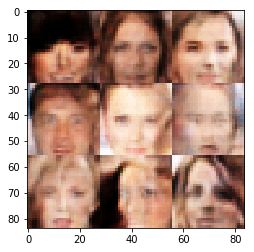

Epoch 1/1... Discriminator Loss: 3.1270... Generator Loss: 0.0827
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.4116


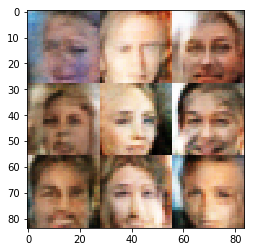

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 0.8665


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.